# Table of contents
1. [Purpose](#purpose)
2. [Inputs](#inputs)
    * [2.1 SQL Database](#subinput1)
3. [Outputs](#outputs)
4. [Constraints](#constraints)
5. [Dependancies](#dependancies)
    * [5.1 Code Language](#subdependancy1)
      * [5.1.1 package requirements](#subsubdepenances)

6. [Code](#code)
7. [Tests](#tests)
8. [Provenance](#provenance)
9. [Citations](#citations)
---

# National Vegetation Classification System (NVCS) Protection Status Summarization
<br/>

## Purpose <a name="purpose"></a>
The USGS Gap Anaysis Program (GAP) and the USDA LANDFIRE working groups have developed land use/land cover datasets for the conterminous United States under the auspices of the vegetation sub-committe of the Federal Geographic Data Committe and the Ecolgoical Society of America's release of the US National Vegetation Classification (USNVC) version 2.01. The USNVC (or NVC) is an 8-level hierarchical classification of the native and non-native vegetation of the nation down to the species association level.

GAP has also produced a composite map of the protected areas witin the United States categorized at four levels of protection status (1-4). The Protected Areas Database (PAD) also contains data on management including manager name (eg. USDA Forest Service, county park, easement) and type (eg. federal, state, local, private).

Intersecting these two datasets facilitates assessment of the areal and spatial extent of protection across various vegetation classes. This biological analysis package illlustrates a readily available, repeatable, transparent and rapid process to conduct just such an assessment.

## Inputs <a name="inputs"></a>
This notebook is intended to provide code used in a summarization for NVCS categories across GAP Protected Areas Database (PAD) status levels - status 1, 2, 3 and 4.
    
It utilizes an SQL server database assembled by intersecting numerous raster data layers created by the Gap Analysis Program including the PAD-US, species habitat maps, boundary layers such as states, counties, LCCs, ecoregions, etc. That database (the GAP Analytic database) at the time of this workflow development was only available on a local server. Hence, all code references a local instance of this database. This code is only replicable given access to a local instance of the database.

* ### SQL Database <a name="subinput1"></a>
This analysis utilizes the GAP Analytic database developed by Linda Scheuk, Anne Davidson, and Leah Dunn at Boise State University. Information about access to a given instance of this database is pending.

## Outputs <a name="outputs"></a>
Interactive HTML charts visualizing the areal extent of NVC classes by manager/manager type, and protection category.

## Constraints <a name="constraints"></a>
Constraints paragraph text

## Dependancies <a name="dependancies"></a>
Code execution and output visualization dependancies

* ### Code Language <a name="subdependancy1"></a>
This code is written in Python 3.x. Earlier versions may be compatible given slight alterations in syntax and package components.
  * #### Python package requirements <a name="subsubdepenances"></a>
  The required packages for proper code execution inlclude:
    - Pandas version 0.2x or above
    - pyodbc version 4.x or above
    - seaborn (statistical data visualization package) version 0.8 or above
    - matplotlib (figures library) version2.2.x or above


## Tests <a name="tests"></a>
Ideas on how this information may be utilized by stakeholders
* ??????????????????????????????????????????????

## Provenance <a name="provenance"></a>
Enter W3C PROV stuff here

#### Accessing the local SQL server instance of the GAP Analytic database


In [2]:
import pyodbc, pandas as pd
import pandas.io.sql as psql
import seaborn as sns
import matplotlib.pyplot as plt

#############################################################################################
################################### LOCAL FUNCTIONS #########################################
#############################################################################################


## --------------Cursor and Database Connections--------------------

def ConnectToDB(connectionStr):
    '''
    (str) -> cursor, connection

    Provides a cursor within and a connection to the database

    Argument:
    connectionStr -- The SQL Server compatible connection string
        for connecting to a database
    '''
    try:
        con = pyodbc.connect(connectionStr)
    except:
        connectionStr = connectionStr.replace('11.0', '10.0')
        con = pyodbc.connect(connectionStr)

    return con.cursor(), con

## ----------------Database Connection----------------------

def ConnectAnalyticDB():
    '''
    Returns a cursor and connection within the GAP analytic database.
    '''
    # Database connection parameters
    dbConStr = """DRIVER=SQL Server Native Client 11.0;
                    SERVER=CHUCK\SQL2014;
                    UID=;
                    PWD=;
                    TRUSTED_CONNECTION=Yes;
                    DATABASE=GAP_AnalyticDB;"""

    return ConnectToDB(dbConStr)


#############################################################################################
#############################################################################################
#############################################################################################


## Connect to the Analytic Database
cur, conn = ConnectAnalyticDB()

In [3]:
print(cur,conn)

<pyodbc.Cursor object at 0x000001D6CACB0378> <pyodbc.Connection object at 0x000001D6CAA99D78>


#### Generating an SQL string to pass to a pandas dataframe

In [4]:
## The SQL to pull out NVC Groups, Classes and PADUS data from the analytic db
sql = """

WITH

/*
	Summarization of total cells within each NVCS Group
*/

NVC_GroupTotal AS (
SELECT 
	gap_landfire.nvc_group,
	sum(lu_boundary_gap_landfire.count) as nGroupTotalCells
FROM	lu_boundary INNER JOIN lu_boundary_gap_landfire INNER JOIN gap_landfire
	ON		lu_boundary_gap_landfire.gap_landfire = gap_landfire.value
	ON		lu_boundary.value = lu_boundary_gap_landfire.boundary
GROUP BY
  gap_landfire.nvc_group

),


/*
	Summary by PAD status for NVCS Groups
*/
NVC_Group AS (  
SELECT
	padus1_4.gap_sts as PADStatus, 
	gap_landfire.nvc_class as NVCClass,
	gap_landfire.nvc_group as NVCGroup,
	sum(lu_boundary_gap_landfire.count) as nCells,
	sum(lu_boundary_gap_landfire.count) * 0.0009 as km2
FROM	lu_boundary INNER JOIN lu_boundary_gap_landfire INNER JOIN gap_landfire
	ON	lu_boundary_gap_landfire.gap_landfire = gap_landfire.value
	ON	lu_boundary.value = lu_boundary_gap_landfire.boundary INNER JOIN padus1_4
	ON	lu_boundary.padus1_4 = padus1_4.objectid
GROUP BY
  padus1_4.gap_sts, 
  gap_landfire.nvc_class,
  gap_landfire.nvc_group

)

/*
	Assemblying data in single output and pivoting on status
*/

	SELECT *
	FROM
	(
	SELECT NVC_Group.PADStatus,
			NVC_Group.NVCClass,
			NVC_Group.NVCGroup,
			NVC_GroupTotal.nGroupTotalCells,
			NVC_Group.nCells
	FROM   NVC_GroupTotal INNER JOIN NVC_Group 
	ON	   NVC_GroupTotal.nvc_group = NVC_Group.NVCGroup
	) AS NVC_Output

	PIVOT
	(
		MAX(NVC_Output.nCells)
		FOR NVC_Output.PADStatus IN ([1], [2], [3], [4])
	) piv
	ORDER BY NVCGroup

"""


#### Passing the SQL and getting a pandas dataframe

In [5]:
# Make a dataframe from the results of the SQL query
df = psql.read_sql(sql, conn)

# Fill all the empty values with 0 and rename columns
df['PAD1'] = df['1'].fillna(0)
df['PAD2'] = df['2'].fillna(0)
df['PAD3'] = df['3'].fillna(0)


# Drop the original PAD status columns
df = df.drop('1', axis=1)
df = df.drop('2', axis=1)
df = df.drop('3', axis=1)
df = df.drop('4', axis=1)


# Recalcute PAD status 4 cell counts for NVC groups using the category
# totals and the sum of status 1 to 3 cell counts
df['PAD4'] = df['nGroupTotalCells'] - (df['PAD1'] + df['PAD2'] + df['PAD3'])

# Calculate area in km2
df['PAD1 km2'] = df['PAD1'] * 0.0009
df['PAD2 km2'] = df['PAD2'] * 0.0009
df['PAD3 km2'] = df['PAD3'] * 0.0009
df['PAD4 km2'] = df['PAD4'] * 0.0009


# Calculate percentages
df['% Protected 1 & 2'] = ((df['PAD1'] + df['PAD2'] ) / df['nGroupTotalCells']) * 100
df['% Protected 1, 2 & 3'] = ((df['PAD1'] + df['PAD2'] + df['PAD3']) / df['nGroupTotalCells']) * 100



In [6]:
df

,NVCClass,NVCGroup,nGroupTotalCells,PAD1,PAD2,PAD3,PAD4,PAD1 km2,PAD2 km2,PAD3 km2,PAD4 km2,% Protected 1 & 2,"% Protected 1, 2 & 3"
0,Forest & Woodland,Appalachian Central Interior Mesic Forest,93498258,1112730.0,3456038.0,5423844.0,83505646.0,1001.4570,3110.4342,4881.4596,75155.0814,4.886474,10.687485
1,Shrub & Herb Vegetation,Appalachian Mafic Glade,90,0.0,51.0,0.0,39.0,0.0000,0.0459,0.0000,0.0351,56.666667,56.666667
2,Forest & Woodland,Appalachian Oak / Chestnut Forest,122684952,3173985.0,5198432.0,16635805.0,97676730.0,2856.5865,4678.5888,14972.2245,87909.0570,6.824323,20.384099
3,Forest & Woodland,Appalachian-Allegheny Northern Hardwood - Coni...,68819751,1661971.0,1723112.0,14374212.0,51060456.0,1495.7739,1550.8008,12936.7908,45954.4104,4.918767,25.805521
4,Shrub & Herb Vegetation,Arid West Interior Freshwater Marsh,4489004,202808.0,955566.0,567215.0,2763415.0,182.5272,860.0094,510.4935,2487.0735,25.804700,38.440353
5,Shrub & Herb Vegetation,Atlantic & Gulf Coast Fresh-Oligohaline Tidal ...,1196644,27028.0,333808.0,64826.0,770982.0,24.3252,300.4272,58.3434,693.8838,30.153997,35.571314
6,Shrub & Herb Vegetation,Atlantic & Gulf Coastal Brackish Tidal Marsh,292233,1371.0,57618.0,34712.0,198532.0,1.2339,51.8562,31.2408,178.6788,20.185605,32.063798
7,Shrub & Herb Vegetation,Atlantic & Gulf Coastal High Salt Marsh,24702655,1472498.0,4113341.0,1901684.0,17215132.0,1325.2482,3702.0069,1711.5156,15493.6188,22.612302,30.310600
8,Shrub & Herb Vegetation,Atlantic & Gulf Coastal Interdunal Marsh & Wet...,2502,540.0,772.0,380.0,810.0,0.4860,0.6948,0.3420,0.7290,52.438050,67.625899
9,Shrub & Herb Vegetation,Atlantic & Gulf Coastal Plain Pondshore & Wet ...,1568855,79575.0,126717.0,359392.0,1003171.0,71.6175,114.0453,323.4528,902.8539,13.149208,36.057124


Now we need to do some manipulation of the % protected data to calculate how many NVC groups fall into the protected bins:
* < 1%
* 1-17%
* 17-50%
* \> 50%

Then, these groups need to be summarized by NVC class (there are 12) EXCLUDING the anthropogenic and non-vegetaion classes:
* Recently Disturbed or Modified
* Open Water
* Nonvascular & Sparse Vascular Rock Vegetation
* Agricultural & Developed Vegetation
* Developed & Other Human Use
* Introduced & Semi Natural Vegetation
* Aquatic Vegetation

That leaves the following NVC classes remaining to summarize protection status percentages:
* Desert & Semi-Desert
* Forest & Woodland
* Open Rock Vegetation
* Polar & High Montane Scrub, Grassland & Barrens
* Shrub & Herb Vegetation

In [7]:
lt1 = len(df[df['% Protected 1 & 2'] < 1])
lt17 = len(df[(df['% Protected 1 & 2'] > 1) & (df['% Protected 1 & 2'] < 17)])
lt50 = len(df[(df['% Protected 1 & 2'] > 17) & (df['% Protected 1 & 2'] < 50)])
gt50 = len(df[df['% Protected 1 & 2'] > 50])

In [8]:
print('Number of NVC groups with less than 1 % protection = ', lt1)
print('Number of NVC groups with more than 1 % and less than 17% protection = ', lt17)
print('Number of NVC groups with more than 17 % and less than 50% protection = ', lt50)
print('Number of NVC groups with more than 50 % protection = ', gt50)

Number of NVC groups with less than 1 % protection =  12
Number of NVC groups with more than 1 % and less than 17% protection =  159
Number of NVC groups with more than 17 % and less than 50% protection =  58
Number of NVC groups with more than 50 % protection =  20


In [9]:
DsDlt1 = len(df[(df['% Protected 1 & 2'] < 1) & (df['NVCClass'] == 'Desert & Semi-Desert')])
print('Number of groups in Desert & Semi-desert class with less than 1% protection:', DsDlt1)

Number of groups in Desert & Semi-desert class with less than 1% protection: 2


In [10]:
FWlt17 = len(df[(df['% Protected 1 & 2'] > 1) & (df['% Protected 1 & 2'] < 17) & (df['NVCClass'] == 'Forest & Woodland')])
print('Number of groups in Forest and Woodland class with less than 17% protection:', FWlt17)

Number of groups in Forest and Woodland class with less than 17% protection: 87


Start manipulating the data to:
* Exclude the anthropogenic and non-vegetation classes
* Limit the columns to only the percent protection status amounts for each class
* Pivot the data to assist in plotting

In [11]:
df2 = df[['NVCClass','NVCGroup','% Protected 1 & 2','% Protected 1, 2 & 3']]
# Pull out only the natural/non-anthropogenic NVC classes
df3 = df2[(df2['NVCClass'] == 'Forest & Woodland') | 
				(df2['NVCClass'] == 'Shrub & Herb Vegetation') | 
				(df2['NVCClass'] == 'Desert & Semi-Desert') | 
				(df2['NVCClass'] == 'Polar & High Montane Scrub, Grassland & Barrens') | 
				(df2['NVCClass'] == 'Open Rock Vegetation')]

# Re-orient the dataframe to generate boxplots for each NVC class
df3_melt = df3.melt(id_vars = 'NVCClass',
                  value_vars = ['% Protected 1 & 2',
                                '% Protected 1, 2 & 3'],
                  var_name = 'Percent Protected',
                  value_name = 'Percent of Mapped Area')


In [12]:
df3_melt.head(5)

,NVCClass,Percent Protected,Percent of Mapped Area
0,Forest & Woodland,% Protected 1 & 2,4.886474
1,Shrub & Herb Vegetation,% Protected 1 & 2,56.666667
2,Forest & Woodland,% Protected 1 & 2,6.824323
3,Forest & Woodland,% Protected 1 & 2,4.918767
4,Shrub & Herb Vegetation,% Protected 1 & 2,25.804700


In [13]:
df3_melt.tail(5)

,NVCClass,Percent Protected,Percent of Mapped Area
471,Forest & Woodland,"% Protected 1, 2 & 3",44.842023
472,Shrub & Herb Vegetation,"% Protected 1, 2 & 3",64.145211
473,Shrub & Herb Vegetation,"% Protected 1, 2 & 3",76.036953
474,Shrub & Herb Vegetation,"% Protected 1, 2 & 3",64.160524
475,Forest & Woodland,"% Protected 1, 2 & 3",17.932157


Finally, plot the data using a boxplot (using the Seaborn statistical visualization package) where classes are on the x-axis and protection status levels (1 & 2 and 1, 2, & 3) are paired together in the plot.

There are numerous formatting options available in matplotlib, a few are utilized here.

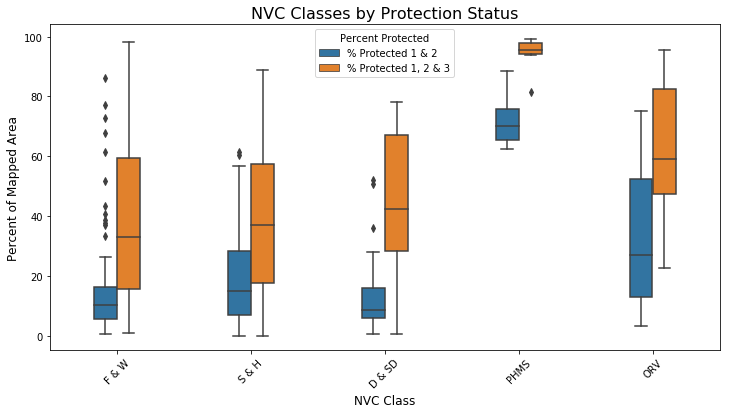

In [14]:
fig, ax = plt.subplots(figsize=(12,6))
plt.xticks(rotation=45)
a = sns.boxplot(data = df3_melt,
                hue = 'Percent Protected',
                x = 'NVCClass',
                y = 'Percent of Mapped Area',
                order = ['Forest & Woodland',
                         'Shrub & Herb Vegetation',
                         'Desert & Semi-Desert',
                         'Polar & High Montane Scrub, Grassland & Barrens',
                         'Open Rock Vegetation'],
                width=0.35,
                ax=ax)
a.set_xlabel('NVC Class', fontsize=12)
a.set_ylabel('Percent of Mapped Area', fontsize=12)
labels = ['F & W','S & H','D & SD','PHMS','ORV']
a.set_xticklabels(labels)
a.set_title('NVC Classes by Protection Status', fontsize=16)

plt.show()


In [15]:
FWlt17 = len(df[(df['% Protected 1 & 2'] < 17) & (df['NVCClass'] == 'Forest & Woodland')])
print('Number of groups in Forest and Woodland class with less than 17% protection:', FWlt17)

Number of groups in Forest and Woodland class with less than 17% protection: 89


In [16]:
FWlt17 = len(df[(df['% Protected 1 & 2'] < 17) & (df['NVCClass'] == 'Forest & Woodland')])
SHlt17 = len(df[(df['% Protected 1 & 2'] < 17) & (df['NVCClass'] == 'Shrub & Herb Vegetation')])
DSDlt17 = len(df[(df['% Protected 1 & 2'] < 17) & (df['NVCClass'] == 'Desert & Semi-Desert')])
PHMSlt17 = len(df[(df['% Protected 1 & 2'] < 17) & (df['NVCClass'] == 'Polar & High Montane Scrub, Grassland & Barrens')])
ORVlt17 = len(df[(df['% Protected 1 & 2'] < 17) & (df['NVCClass'] == 'Open Rock Vegetation')])
print('Number of groups in Forest and Woodland class with less than 17% protection:', FWlt17)
print('Number of groups in Shrub and Herb Veg. class with less than 17% protection:', SHlt17)
print('Number of groups in Desert/Semi-desert class with less than 17% protection:', DSDlt17)
print('Number of groups in Polar High Montane class with less than 17% protection:', PHMSlt17)
print('Number of groups in Open Rock Veg. class with less than 17% protection:', ORVlt17)

Number of groups in Forest and Woodland class with less than 17% protection: 89
Number of groups in Shrub and Herb Veg. class with less than 17% protection: 44
Number of groups in Desert/Semi-desert class with less than 17% protection: 24
Number of groups in Polar High Montane class with less than 17% protection: 0
Number of groups in Open Rock Veg. class with less than 17% protection: 3


## Citations <a name="citations"></a>
Aycrigg, J. L., Davidson, A., Svancara, L. K., Gergely, K. J., McKerrow, A.J., & Scott, M. (2013). Representation of ecological systems within the protected areas network of the continental United States. PLoSONE, 8(1), e54689. https://doi.org/10.1371/journal.pone.0054689

U.S. Geological Survey, Gap Analysis Program. (2016). Protected Areas Database of the United States (PAD-US), version 1.4 Combined Feature Class. https://doi.org/10.5066/F7G73BSZ